In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN,LSTM
from tensorflow.keras.models import Sequential
import timeit


In [6]:
data_size = 5000 # 116189
train_size = 3000 # set if total data size 5000 
epoch = 10

# New section - Data preprocess

In [98]:
df_pv = pd.read_csv('solar_panel_power.csv', index_col=0, parse_dates=['datetime'])
df_pv

,power,year,month,week,day,hour,minute,dayofweek
datetime,,,,,,,,
2020-01-01 00:00:00,0.0,2020,1,1,1,0,0,2
2020-01-01 00:30:00,0.0,2020,1,1,1,0,30,2
2020-01-01 01:00:00,0.0,2020,1,1,1,1,0,2
2020-01-01 01:30:00,0.0,2020,1,1,1,1,30,2
2020-01-01 02:00:00,0.0,2020,1,1,1,2,0,2
...,...,...,...,...,...,...,...,...
2020-03-29 21:30:00,0.0,2020,3,13,29,21,30,6
2020-03-29 22:00:00,0.0,2020,3,13,29,22,0,6
2020-03-29 22:30:00,0.0,2020,3,13,29,22,30,6


In [23]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

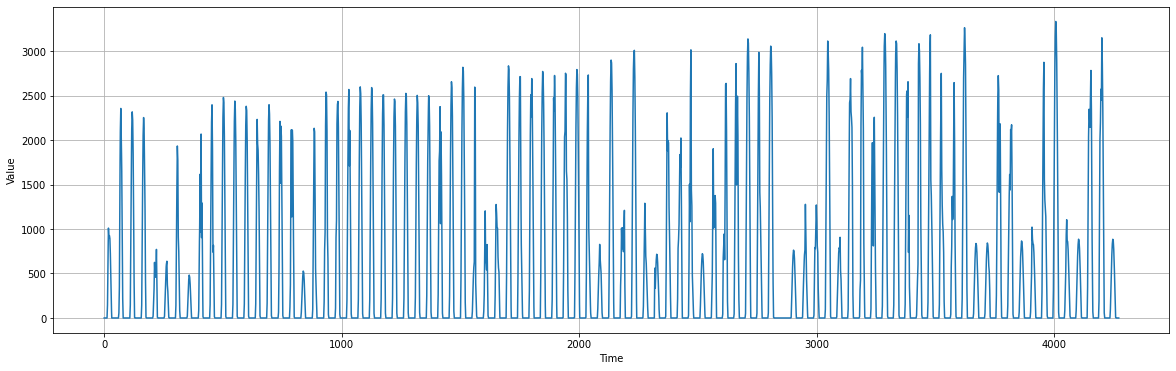

In [24]:
plt.figure(figsize=(20,6))
plot_series(df_pv.index, df_pv['power'])
plt.show()

In [47]:
df = df_pv.set_index("datetime")
print(df.head(5))
df.isnull().sum().sum()

                     power
datetime                  
2020-01-01 00:00:00    0.0
2020-01-01 00:30:00    0.0
2020-01-01 01:00:00    0.0
2020-01-01 01:30:00    0.0
2020-01-01 02:00:00    0.0


0

In [55]:
def add_features(datasets):
    datasets.index = pd.to_datetime(datasets.index)
    datasets['year'] = datasets.index.year
    datasets['month'] = datasets.index.month
    datasets['week'] = datasets.index.week
    datasets['day'] = datasets.index.day
    datasets['hour'] = datasets.index.hour
    datasets['minute'] = datasets.index.minute
    datasets['dayofweek'] = datasets.index.dayofweek
    return datasets

In [57]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [60]:
# load dataset
datasets = add_features(df)
values = datasets.values
# integer encode direction
encoder = LabelEncoder()
values[:,-1] = encoder.fit_transform(values[:,-1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()
# # drop columns we don't want to predict
reframed.drop(reframed.columns[list(range(len(datasets.columns)+1, 2*len(datasets.columns)))], axis=1, inplace=True)
print(reframed.head)

<bound method NDFrame.head of       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1           0.0        0.0        0.0        0.0   0.000000   0.000000   
2           0.0        0.0        0.0        0.0   0.000000   0.000000   
3           0.0        0.0        0.0        0.0   0.000000   0.043478   
4           0.0        0.0        0.0        0.0   0.000000   0.043478   
5           0.0        0.0        0.0        0.0   0.000000   0.086957   
...         ...        ...        ...        ...        ...        ...   
4267        0.0        0.0        1.0        1.0   0.933333   0.913043   
4268        0.0        0.0        1.0        1.0   0.933333   0.913043   
4269        0.0        0.0        1.0        1.0   0.933333   0.956522   
4270        0.0        0.0        1.0        1.0   0.933333   0.956522   
4271        0.0        0.0        1.0        1.0   0.933333   1.000000   

      var7(t-1)  var8(t-1)  var1(t)  
1           0.0   0.333333      0.0  
2    

C:\Users\maury\AppData\Local\Temp/ipykernel_21584/932595607.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  datasets['week'] = datasets.index.week


In [61]:
# train_ratio = 0.8
test_len = 334
values = reframed.values
train_data = len(values) - test_len
print(train_data)

timesteps = 1
train = values[:train_data, :]
test = values[train_data:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], timesteps, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], timesteps, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

3937
(3937, 1, 8) (3937,) (334, 1, 8) (334,)


In [62]:
print('X_train.shape = ',train_X.shape)
print('y_train.shape = ', train_y.shape)
print('X_test.shape = ', test_X.shape)
print('y_test.shape = ',test_y.shape)

X_train.shape =  (3937, 1, 8)
y_train.shape =  (3937,)
X_test.shape =  (334, 1, 8)
y_test.shape =  (334,)


# New section - LSTM Model

Epoch 1/20
124/124 [==============================] - 26s 68ms/step - loss: 0.0761 - mean_absolute_error: 0.1615 - val_loss: 0.0788 - val_mean_absolute_error: 0.1872
Epoch 2/20
124/124 [==============================] - 6s 52ms/step - loss: 0.0597 - mean_absolute_error: 0.1906 - val_loss: 0.0597 - val_mean_absolute_error: 0.2145
Epoch 3/20
124/124 [==============================] - 6s 51ms/step - loss: 0.0291 - mean_absolute_error: 0.1417 - val_loss: 0.0168 - val_mean_absolute_error: 0.0857
Epoch 4/20
124/124 [==============================] - 7s 53ms/step - loss: 0.0095 - mean_absolute_error: 0.0704 - val_loss: 0.0117 - val_mean_absolute_error: 0.0603
Epoch 5/20
124/124 [==============================] - 6s 51ms/step - loss: 0.0056 - mean_absolute_error: 0.0494 - val_loss: 0.0072 - val_mean_absolute_error: 0.0523
Epoch 6/20
124/124 [==============================] - 7s 55ms/step - loss: 0.0041 - mean_absolute_error: 0.0416 - val_loss: 0.0046 - val_mean_absolute_error: 0.0460
Epoch 7/2

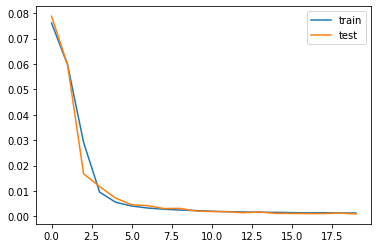

In [71]:
lstm_model = Sequential([
LSTM(50,  activation="relu", input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True),
LSTM(50, activation="relu", return_sequences=True),
LSTM(50, activation="relu", return_sequences=True),
LSTM(50, activation="relu", return_sequences=True),
LSTM(units=25, activation="relu"),
Dense(1)])
loss = tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
lstm_model.compile(loss=loss, optimizer=optimizer, metrics=tf.keras.losses.mean_absolute_error)
lstm_model.summary
history1 = lstm_model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=20)
# plot history
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show()

In [73]:
trainScore = lstm_model.evaluate(train_X, train_y, verbose=0)
print('Train loss:', trainScore[0])
print('Train accuracy:', trainScore[1])

Train loss: 0.0012350142933428288
Train accuracy: 0.017500484362244606


In [74]:
testScore = lstm_model.evaluate(train_X, train_y, verbose=0)
print('Test loss:', testScore[0]) 
print('Test accuracy:', testScore[1])

Test loss: 0.0012350142933428288
Test accuracy: 0.017500484362244606


In [76]:
lstm_predictions = lstm_model.predict(test_X)

lstm_score = r2_score(test_y, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.9867868368985835


In [95]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power')
    plt.plot(predicted, alpha=0.7, color='green',label='Predicted power')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power scale')
    plt.legend()
    plt.show()

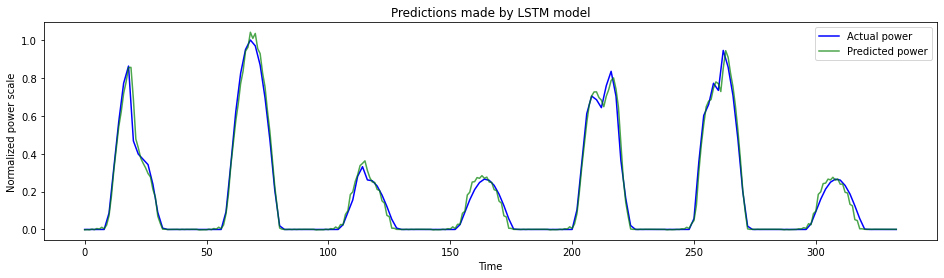

In [96]:
plot_predictions(test_y, lstm_predictions, "Predictions made by LSTM model")

# New section - RNN Model

In [99]:
# Build Simple RNN 
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 1, 40)             1960      
_________________________________________________________________
dropout_24 (Dropout)         (None, 1, 40)             0         
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 1, 40)             3240      
_________________________________________________________________
dropout_25 (Dropout)         (None, 1, 40)             0         
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 40)                3240      
_________________________________________________________________
dropout_26 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)               

In [100]:
start_training_time = timeit.default_timer()
rnn_model.compile(optimizer="adam",loss="MSE", metrics=['mean_squared_error'])
rnn_model.fit(train_X, train_y, epochs=30, batch_size=1000)
stop_training_time = round((timeit.default_timer() - start_training_time))
print('Training Time: ', stop_training_time)

Epoch 1/30
4/4 [==============================] - 6s 19ms/step - loss: 0.1304 - mean_squared_error: 0.1304
Epoch 2/30
4/4 [==============================] - 0s 17ms/step - loss: 0.0996 - mean_squared_error: 0.0996
Epoch 3/30
4/4 [==============================] - 0s 25ms/step - loss: 0.0754 - mean_squared_error: 0.0754
Epoch 4/30
4/4 [==============================] - 0s 19ms/step - loss: 0.0596 - mean_squared_error: 0.0596
Epoch 5/30
4/4 [==============================] - 0s 18ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 6/30
4/4 [==============================] - 0s 23ms/step - loss: 0.0427 - mean_squared_error: 0.0427
Epoch 7/30
4/4 [==============================] - 0s 27ms/step - loss: 0.0360 - mean_squared_error: 0.0360
Epoch 8/30
4/4 [==============================] - 0s 23ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 9/30
4/4 [==============================] - 0s 19ms/step - loss: 0.0304 - mean_squared_error: 0.0304
Epoch 10/30
4/4 [====================

In [101]:
rnn_predictions = rnn_model.predict(test_X)

rnn_score = r2_score(test_y,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9616818918098117


In [102]:
rnntrainScore = rnn_model.evaluate(train_X, train_y, verbose=0)
print('Train loss:', rnntrainScore[0]) 
print('Train accuracy:', rnntrainScore[1])

Train loss: 0.0030124967452138662
Train accuracy: 0.0030124967452138662


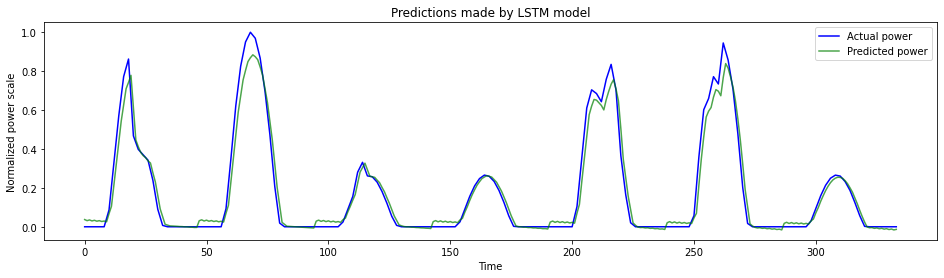

In [103]:
plot_predictions(test_y, rnn_predictions, "Predictions made by LSTM model")